# INITIALISATIONS

In [482]:
#CODE TO INITIALISE TENSORFLOW

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))
print("Success!")

#Prints the devices in use. The next time I open this, should be configured to only use GPU 3
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Success!


In [483]:
#IMPORTS 

import numpy as np
import math
import random
import os
import re
import matplotlib
import time

from itertools import groupby
from StringIO import StringIO
from __future__ import division
from mpl_toolkits.axes_grid1 import make_axes_locatable

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.layers import Lambda
from keras import backend as K
from keras.engine.topology import Layer
from keras.layers.merge import concatenate
from keras.layers import SpatialDropout2D
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Merge

import pyjet
from pyjet import cluster, DTYPE_PTEPM
from pyjet.testdata import get_event

import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.pyplot import cm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.collections import PatchCollection

import scipy
import scipy.optimize as opt
from scipy.interpolate import griddata
from scipy import interpolate
from scipy.optimize import least_squares

In [484]:
#VARIABLES

width = 40
height = 40 #width, height of pictures
signalCross = 5.458e-11
backgroundCross = 2.048e-06 #cross-section of processes in millibarns

actual_background_cross=2.84e-9 #barns
average_number_accepted=2162

actual_signal_cross = np.average([1.738e-14,1.7277e-14])
signal_accepted = np.average([8708-189,8827-172])

# READING IN DATA

In [486]:
#FUNCTIONS NEEDED TO READ AND PROCESS DATA

def return_event_list(fileName,max_Read = float("inf"),weighted=0,pt_cut=0):
    
    printed = 0
    
    event_list = [];mass_list = [];weight_list = [];
    tmp_events = open(fileName).read().split("\n\n")[:-1]
    for x in tmp_events:
        try:
            if len(event_list) == max_Read:
                return(event_list,mass_list)
            if weighted == 0:
                mass_list.append(float(x[x.rfind("\n")+1:-1]))
                to_cut = np.array(np.genfromtxt(StringIO(x[:x.rfind("\n")]),delimiter=","))
                event_list.append(to_cut[[x[0] > pt_cut for x in to_cut]])
            else:
                weight_list.append(float(x[x.rfind("\n")+1:]))
                mass_list.append(float(x[x.rfind("\n",0,x.rfind("\n")-1)+1:x.rfind("\n")+1]))
                to_cut = np.genfromtxt(StringIO(x[:x.rfind("\n")]),delimiter=",")
                event_list.append(to_cut[[x[0] > pt_cut for x in to_cut]])
        except:
            print('We failed to turn your CSV into an np array. Make sure you have the correct format. ')
            return
    if weighted == 0:
        #print(mass_list[0])
        return(event_list,mass_list)
    else:
        return(event_list,mass_list,weight_list)

def return_image_list(event_list):
    image_list = []
    image_0 = np.zeros((width,height)) #Charged pt
    image_1 = np.zeros((width,height)) #Neutral pt
    image_2 = np.zeros((width,height)) #Charged multiplicity
    for z in range(len(event_list)):
        image_0 = np.zeros((width,height));image_1 = np.zeros((width,height));image_2 = np.zeros((width,height))
        for x in range(len(event_list[z])):
            phi_index = math.floor(width*event_list[z][x,2]//(2*math.pi)+width//2)
            eta_index = math.floor(height*event_list[z][x,1]//10+height/2)
            eta_index = min(eta_index,height-1)
            eta_index = max(0,eta_index)
            phi_index = int(phi_index);eta_index = int(eta_index)
            if (event_list[z][x,5] == 0):
                image_0[phi_index,eta_index] = image_0[phi_index,eta_index] + event_list[z][x,0]
            elif (event_list[z][x,5] == 1):
                image_1[phi_index,eta_index] = image_1[phi_index,eta_index] + event_list[z][x,0]
                image_2[phi_index,eta_index] = image_2[phi_index,eta_index] + 1
        image_0 = np.divide(image_0,np.sum(image_0))
        image_1 = np.divide(image_1,np.sum(image_1))
        image_2 = np.divide(image_2,np.sum(image_2))
        image_list.append(np.array([image_0,image_1,image_2]))
    return(image_list)

def load_events(event_type,debug = 0, max_Read = float("inf"), max_Files = float("inf"), weighted=0, \
                path = "/data1/users/jzlin/NLO/", contains = "philback", pt_cut = 0):
    print("Loading events for " + event_type)
    reading_event_list,reading_mass_list = [],[]
    reading_image_list = []
    reading_weight_list = []
    files_Read = 0
    for i in os.listdir(path):
        if (files_Read == max_Files):
            break
        if len(reading_event_list) >= max_Read:
            return(reading_event_list,reading_mass_list,reading_image_list,files_Read)
        if 'swp' in i:
            continue
        if os.path.isfile(os.path.join(path,i)) and (event_type+contains) in i:
            if debug==1:
                print(i)
                print(os.path.join(path,i))
            if weighted==0:
                print(i)
                temp_event_list,temp_mass_list = return_event_list(os.path.join(path,i),pt_cut=pt_cut)
            else:
                temp_event_list,temp_mass_list,temp_weight_list = return_event_list(os.path.join(path,i),
                                                                                    weighted=1,pt_cut=pt_cut)
                reading_weight_list = reading_weight_list = temp_weight_list
            temp_image_list = return_image_list(temp_event_list)
            if (len(temp_image_list) != len(temp_mass_list)):
                print("Something has gone wrong when reading the file")
                print(os.path.join(path,i))
            reading_event_list = reading_event_list + temp_event_list
            reading_mass_list = reading_mass_list + temp_mass_list
            reading_image_list = reading_image_list + temp_image_list
            files_Read = files_Read + 1
            print("Read " + str(files_Read) + " number of files\r")
    if weighted==0:
        return(reading_event_list,reading_mass_list,reading_image_list,files_Read)
    else:
        return(reading_event_list,reading_mass_list,reading_image_list,files_Read,reading_weight_list)
    
def fix_phi(phi):
    while phi > math.pi:
        phi = phi - 2*math.pi
    while phi < -math.pi:
        phi = phi + 2*math.pi
    return phi

def return_fine_image_list(event_list, event_list_clustered, granularity, which_jet = 0):
    image_list = []
    image_0 = np.zeros((width,height)) #Charged pt
    image_1 = np.zeros((width,height)) #Neutral pt
    image_2 = np.zeros((width,height)) #Charged multiplicity

    for z in range(len(event_list)):
        image_0 = np.zeros((width,height))
        image_1 = np.zeros((width,height))
        image_2 = np.zeros((width,height))
        for x in range(len(event_list[z])):
            
            try:
                phi_index = (event_list[z][x,2]-event_list_clustered[z][which_jet].phi)
            except:
                print(z)
            #At this point, phi_index is just delta_phi, which could be anywhere from -2pi to 2pi
            if (phi_index % (2*math.pi) >= (width//2)*granularity) and (phi_index % (2*math.pi) <= 2*math.pi-(width//2)*granularity):
                continue
                #This gets rid of the delta phi's that are far away from the jet
            phi_index = phi_index % (2*math.pi)
            if phi_index > math.pi:
                 phi_index = phi_index - 2*math.pi   
            phi_index = int(math.floor(phi_index/granularity)) #should be good now
            if (phi_index > (width//2)) or (phi_index < -(width//2)):
                print(phi_index)
            phi_index = phi_index + (width//2)
            

            eta_index = int(math.floor((event_list[z][x,1]-event_list_clustered[z][which_jet].eta)/granularity) + height//2)
            if eta_index >= height:
                continue
            if eta_index < 0:
                continue
            
            #finally, lets fill
            if (event_list[z][x,5] == 0):
                image_0[phi_index,eta_index] = image_0[phi_index,eta_index] + event_list[z][x,0]
            elif (event_list[z][x,5] == 1):
                image_1[phi_index,eta_index] = image_1[phi_index,eta_index] + event_list[z][x,0]
                image_2[phi_index,eta_index] = image_2[phi_index,eta_index] + 1

        #Now, lets go through and normalise to 255
        image_0 = np.divide(image_0,np.sum(image_0))
        image_1 = np.divide(image_1,np.sum(image_1))
        image_2 = np.divide(image_2,np.sum(image_2))
        image_list.append(np.array([image_0,image_1,image_2]))
    return(image_list)

def cluster_event(event_list):
    event_list_clustered = []
    for x in range(len(event_list)):
        to_Cluster = np.array([event_list[x][:,0],event_list[x][:,1],event_list[x][:,2],event_list[x][:,3]])
        to_Cluster = np.swapaxes(to_Cluster,0,1)
        to_Cluster = np.core.records.fromarrays(to_Cluster.transpose(), 
                                             names='pT, eta, phi, mass',
                                             formats = 'f8, f8, f8,f8')
        sequence_Cluster = cluster(to_Cluster, R = 0.8,p = -1)
        jets_Cluster = sequence_Cluster.inclusive_jets()
        event_list_clustered.append(jets_Cluster)
    return(event_list_clustered)

def recluster_event(cluster_list):
    reclustered_list= []
    for i in range(len(cluster_list)):
        sequence_Cluster = cluster((cluster_list[i][0]), R=0.2,p=-1)
        jets_Cluster = sequence_Cluster.inclusive_jets()
        reclustered_list.append(jets_Cluster)
    return(reclustered_list)

def dphi(phi,phi_c):
    #Returns the difference in phi between phi, and phi_center
    #This is returnede as a float between (-PI, PI)
    
    dphi_temp = phi - phi_c
    while dphi_temp > np.pi:
        dphi_temp = dphi_temp - 2*np.pi
    while dphi_temp < -np.pi:
        dphi_temp = dphi_temp + 2*np.pi
    return (dphi_temp)

def return_fine_image_list_reclustered(event_list, event_list_clustered, radius, which_jet = 0,verbose = False):
    image_list = []
    image_0 = np.zeros((width,height)) #Charged pt
    image_1 = np.zeros((width,height)) #Neutral pt
    image_2 = np.zeros((width,height)) #Charged multiplicity
    
    no_two = 0

    for z in range(len(event_list)):
        image_0 = np.zeros((width,height))
        image_1 = np.zeros((width,height))
        image_2 = np.zeros((width,height))
        
        if (len(event_list_clustered[z]) > 1):
            #First, let's find the direction of the second-hardest jet relative to the first-hardest subjet
            phi_dir = -(dphi(event_list_clustered[z][1].phi,event_list_clustered[z][0].phi))
            eta_dir = -(event_list_clustered[z][1].eta - event_list_clustered[z][0].eta)
            #Norm difference:
            norm_dir = np.linalg.norm([phi_dir,eta_dir])
            #This is now the y-hat direction. so we can actually find the unit vector:
            y_hat = np.divide([phi_dir,eta_dir],np.linalg.norm([phi_dir,eta_dir]))
            #and we can find the x_hat direction as well
            x_hat = np.array([y_hat[1],-y_hat[0]]) 
        else:
            no_two = no_two + 1
            #continue
            
        if verbose==True:
            print(x_hat,y_hat,norm_dir)
            
        
        for x in range(len(event_list[z])):
            if (len(event_list_clustered[z]) == 1):
                #In the case that the reclustering only found one hard jet (that seems kind of bad, but hey)
                #no_two = no_two+1
                new_coord = [dphi(event_list[z][x,2],event_list_clustered[z][0].phi),event_list[z][x,1]-event_list_clustered[z][0].eta]
                indxs = [math.floor(width*new_coord[0]/(radius*1.5))+width//2,math.floor(height*(new_coord[1])/(radius*1.5))+height//2]
            else:
                #Now, we want to express an incoming particle in this new basis:
                part_coord = [dphi(event_list[z][x,2],event_list_clustered[z][0].phi),event_list[z][x,1]-event_list_clustered[z][0].eta]
                new_coord = np.dot(np.array([x_hat,y_hat]),part_coord)
                #Now, we want to cast these new coordinates into our array
                indxs = [math.floor(width*new_coord[0]/(radius*1.5))+width//2,math.floor(height*(new_coord[1]+norm_dir/1.5)/(radius*1.5))+height//2]
                
            if indxs[0] >= width or indxs[1] >= height or indxs[0] <= 0 or indxs[1] <= 0:
                continue
            phi_index = int(indxs[0]); eta_index = int(indxs[1])
            #finally, lets fill
            if (event_list[z][x,5] == 0):
                image_0[phi_index,eta_index] = image_0[phi_index,eta_index] + event_list[z][x,0]
            elif (event_list[z][x,5] == 1):
                image_1[phi_index,eta_index] = image_1[phi_index,eta_index] + event_list[z][x,0]
                image_2[phi_index,eta_index] = image_2[phi_index,eta_index] + 1

        #Now, lets go through and normalise to 255
        if (np.sum(image_0) == 0 or np.sum(image_1) == 0 or np.sum(image_2) == 0):
            image_list.append(np.array([image_0,image_1,image_2]))
            continue
        image_0 = np.divide(image_0,np.sum(image_0))
        image_1 = np.divide(image_1,np.sum(image_1))
        image_2 = np.divide(image_2,np.sum(image_2))
        image_list.append(np.array([image_0,image_1,image_2]))
    print("no two " + str(no_two))
    return(image_list)

def y(p):
    return ((1/2)*math.log((p.e+p.pz)/(p.e-p.pz)))

def R(con1,con2):
    return (((con1.eta-con2.eta)**2+dphi(con1.phi,con2.phi)**2)**(1/2))

def R_y(con1,con2):
    return (((y(con1)-y(con2))**2+dphi(con1.phi,con2.phi)**2)**(1/2))

def N_2(jcon):
    #Takes jcon, jet constituents
    p_x_total = np.sum([con.px for con in jcon])
    p_y_total = np.sum([con.py for con in jcon])
    p_total = (p_x_total**2+p_y_total**2)**(1/2)
    
    v_1e2 = 0
    for i in range(len(jcon)):
        for j in range(i+1,len(jcon)):
            v_1e2 = v_1e2+ jcon[i].pt*jcon[j].pt*R(jcon[i],jcon[j])/(p_total**2)
    v_2e3 = 0
    for i in range(len(jcon)):
        for j in range(i+1,len(jcon)):
            for k in range(j+1,len(jcon)):
                v_2e3 = v_2e3 + jcon[i].pt*jcon[j].pt*jcon[j].pt*min(R(jcon[i],jcon[j])*R(jcon[i],jcon[k]),
                                                                     R(jcon[j],jcon[k])*R(jcon[i],jcon[j]),
                                                        R(jcon[i],jcon[k])*R(jcon[j],jcon[k]))/(p_total**3)
    return v_2e3/(v_1e2**2)

class myJet(object):
    def __init__(self,px,py,pz):
        self.px = px; self.py = py; self.pz = pz; self.pt = (px**2+py**2)**(1/2)
        self.phi = math.atan2(py,px); self.eta = -math.log(math.tan(math.atan2(self.pt,self.pz)/2));

class Node(object):
    def __init__(self,data):
        self.data = data
        self.children = []
    def add_child(self,obj):
        self.children.append(obj)

def softdrop(jcon,z=0.1,debug = 0):
    #Takes the constituents of a jet, and softdrops it.
    #First, we need to step through the jet and build the tree of clustering
    #Since we are reclustering the whole thing; just take R = 1; i.e. dont need to think about it
    def distance(con1,con2):
        return R(con1,con2)**2
    pseudojets = []
    nodes = []
    for con in jcon:
        x = Node([con,1])
        #pseudojets.append(x)
        nodes.append(x) #1 means its still a pseudojet; i.e. not been clustered
    def how_many_pseudo(nodes):
        how_many = 0
        for node in nodes:
            if node.data[1] == 1:
                how_many = how_many + 1
        return how_many
    if debug == 1:
        print("len(nodes) : " + str(len(nodes)))
        #print(nodes)
    rep = 0
    while how_many_pseudo(nodes) > 1:
        #print(how_many_pseudo(nodes))
        min_distance = float("inf")
        min_index = [0,0]
        for i in range(0,len(nodes)):
            if nodes[i].data[1] == 0: #Its already part of something else
                continue
            for j in range(i+1,len(nodes)):
                if nodes[j].data[1] == 0:
                    continue
                if distance(nodes[i].data[0],nodes[j].data[0]) < min_distance:
                    min_index[0] = i; min_index[1] = j; 
                    min_distance = distance(nodes[i].data[0],nodes[j].data[0])
        i = min_index[0];j=min_index[1];
        new_node = Node([myJet(nodes[i].data[0].px+nodes[j].data[0].px,
                           nodes[i].data[0].py+nodes[j].data[0].py,
                           nodes[i].data[0].pz+nodes[j].data[0].pz),1])
        new_node.add_child(nodes[i])
        new_node.add_child(nodes[j])
        nodes.append(new_node)
        nodes[i].data[1] = 0
        nodes[j].data[1] = 0
    
    #print(nodes)

    to_check = [] #nodes to check
    for i in range(len(nodes)):
        if nodes[i].data[1] == 1:
            to_check.append(nodes[i])
    softcon = []
    while len(to_check) > 0:
        #print(to_check)
        our_childs = to_check[0].children
        #print(our_childs)
        if len(our_childs) == 0:
            softcon.append(to_check[0].data[0])
            to_check.pop(0)
            continue
        if min(our_childs[0].data[0].pt,our_childs[1].data[0].pt)/   \
                        (our_childs[0].data[0].pt+our_childs[1].data[0].pt) > z:
            to_check.append(our_childs[0])
            to_check.append(our_childs[1])
        elif our_childs[0].data[0].pt > our_childs[1].data[0].pt:
            to_check.append(our_childs[0])
        else:
            to_check.append(our_childs[1])
        to_check.pop(0)
    return softcon

In [1282]:
#Reading in files; madgraph style, single large file (!!pT cut!!)
num_signal_files = 0
num_background_files = 1
background_event_list,background_mass_list,background_image_list,num_background_files = \
    load_events("actual", max_Files=num_background_files,path="/data1/users/jzlin/MLM/background_7413/",\
                contains="_actual",pt_cut=1)
num_background_files = 15693

signal_event_list,signal_mass_list,signal_image_list,num_signal_files = \
    load_events("actual", max_Read = len(background_event_list),path="/data1/users/jzlin/MLM/heavy_signal/",\
                contains="_signal",pt_cut=1)

#Check size of dataset
print(len(background_mass_list),len(signal_mass_list))

#Zero centering
tmp_av = np.average(np.concatenate((background_image_list,signal_image_list)),axis=0)
tmp_sd = np.std(np.concatenate((background_image_list,signal_image_list)),axis=0)
save_av_img = tmp_av; save_sd_img = tmp_sd;
for i in range(len(background_image_list)):
    background_image_list[i] = np.divide((background_image_list[i] - tmp_av),(tmp_sd+1e-5)) #perhaps add some r to temp_sd to suppress noise
for i in range(len(signal_image_list)):
    signal_image_list[i] = np.divide((signal_image_list[i] - tmp_av),(tmp_sd+1e-5))#/tmp_sd
    
background_mass_window = np.logical_and(np.array(background_mass_list) > 115,np.array(background_mass_list) < 135)

Loading events for actual
actual_actualMLM_final15693.csv
Read 1 number of files
Loading events for actual
actual_signalMLM_run_03_0_seed_61690.csv
Read 1 number of files
actual_signalMLM_run_03_3_seed_82962.csv
Read 2 number of files
actual_signalMLM_run_03_3_seed_99614.csv
Read 3 number of files
actual_signalMLM_run_03_0_seed_57602.csv
Read 4 number of files
actual_signalMLM_run_03_3_seed_83577.csv
Read 5 number of files
actual_signalMLM_run_03_3_seed_70357.csv
Read 6 number of files
actual_signalMLM_run_03_1_seed_85118.csv
Read 7 number of files
actual_signalMLM_run_03_7_seed_81419.csv
Read 8 number of files
actual_signalMLM_run_03_1_seed_30995.csv
Read 9 number of files
actual_signalMLM_run_03_6_seed_62807.csv
Read 10 number of files
actual_signalMLM_run_03_2_seed_83303.csv
Read 11 number of files
actual_signalMLM_run_03_1_seed_88402.csv
Read 12 number of files
actual_signalMLM_run_03_2_seed_75869.csv
Read 13 number of files
actual_signalMLM_run_03_7_seed_32689.csv
Read 14 number o

In [ ]:
#Clusters events into jets into background/signal_event_list_clustered
background_event_list_clustered = cluster_event(background_event_list)
signal_event_list_clustered = cluster_event(signal_event_list)

In [491]:
#Reclustering the events (i.e. clustering within events)
background_reclustered = recluster_event(background_event_list_clustered)
signal_reclustered = recluster_event(signal_event_list_clustered)

In [1285]:
background_recluster_images = return_fine_image_list_reclustered(background_event_list,
                                                           background_reclustered,0.8)
signal_recluster_images = return_fine_image_list_reclustered(signal_event_list,
                                                           signal_reclustered,0.8)

background_recluster_images_nonstandard,signal_recluster_images_nonstandard = (np.copy(background_recluster_images),
                                                                              np.copy(signal_recluster_images))
tmp_av = np.average(np.concatenate((background_recluster_images,signal_recluster_images)),axis=0)
tmp_sd = np.std(np.concatenate((background_recluster_images,signal_recluster_images)),axis=0)
save_av_rc = tmp_av; save_sd_rc = tmp_sd;
for i in range(len(background_recluster_images)):
    background_recluster_images[i] = np.divide((background_recluster_images[i] - tmp_av),tmp_sd+1e-5) #perhaps add some r to temp_sd to suppress noise
for i in range(len(signal_recluster_images)):
    signal_recluster_images[i] = np.divide((signal_recluster_images[i] - tmp_av),tmp_sd+1e-5)

no two 38
no two 16


In [ ]:
#Here are some substructure variables

def find_new_var_3(reclustered,clustered,pt_cut = 1):
    #The point is that many jets only have two subjets so the above is not really that efficient... hm
    new_var = []
    for sqn in range(len(reclustered)):
        net_R = 0
        jet = clustered[sqn][0]
        con = jet.constituents()
        sub_1 = reclustered[sqn][0]
        try:
            sub_2 = reclustered[sqn][1]
        except:
            #print('ah')
            sub_2 = sub_1
        for i in range(len(con)):
            if con[i].pt < pt_cut:
                continue
            #net_R = net_R + (con[i].pt/jet.pt)**(-1)*(R(sub_1,con[i])*R(sub_2,con[i]))
            net_R = net_R + (R(sub_1,con[i])*R(sub_2,con[i]))
        new_var.append(-net_R)
    return new_var

def find_new_var_3_norm(reclustered,clustered,pt_cut=1):
    new_var = []
    for sqn in range(len(reclustered)):
        net_R = 0
        jet = clustered[sqn][0]
        con = jet.constituents()
        sub_1 = reclustered[sqn][0]
        max_rad_1 = 0
        max_rad_2 = 0
        for i in range(0,len(con)):
            if R(con[i],sub_1) > max_rad_1:
                max_rad_1 = R(con[i],sub_1)
        try:
            sub_2 = reclustered[sqn][1]
        except:
            print('ah')
            sub_2 = sub_1
        for i in range(0,len(con)):
                if R(con[i],sub_2) > max_rad_2:
                    max_rad_2 = R(con[i],sub_2)

        I = np.zeros((2,2))
        basis_1 = np.array([jet.px,jet.py,jet.pz])/np.linalg.norm(np.array([jet.px,jet.py,jet.pz]))
        basis_2 = np.array([-jet.py,jet.px,0])/np.linalg.norm(np.array([-jet.py,jet.px,0]))
        basis_3 = np.cross(basis_1,basis_2)
        transform = np.array([basis_1,basis_2,basis_3])
        
        norm_factor = 0
        
        for i in range(0,len(con)):
            if con[i].pt < pt_cut:
                continue
            new_par = transform.dot(np.array([con[i].px,con[i].py,con[i].pz]))
            rel_pt = (new_par[1]**2+new_par[2]**2)**(1/2)
            norm_factor = norm_factor + rel_pt
            net_R = net_R + (rel_pt)*(R(sub_1,con[i])*R(sub_2,con[i]))/(max_rad_1*max_rad_2)
        net_R = net_R/norm_factor
        new_var.append(net_R)
    return new_var
        
def find_new_var_N_2(reclustered,clustered):
    new_var = []
    for i in clustered:
        jcon = i[0].constituents()
        #Takes jcon, jet constituents
        p_total = np.sum([con.pt for con in jcon])
        v_1e2 = 0
        for i in range(len(jcon)):
            for j in range(i+1,len(jcon)):
                v_1e2 = v_1e2+ jcon[i].pt*jcon[j].pt*R(jcon[i],jcon[j])/(p_total**2)
        #v_1e2 = np.sum([[(con1.pt/p_total)*(con2.pt/p_total)*R(con1,con2) for con1 in jcon] for con2 in jcon])/2
        v_2e3 = 0
        for i in range(len(jcon)):
            for j in range(i+1,len(jcon)):
                for k in range(j+1,len(jcon)):
                    v_2e3 = v_2e3 + jcon[i].pt*jcon[j].pt*jcon[j].pt*min(R(jcon[i],jcon[j]),R(jcon[j],jcon[k]),
                                                                            R(jcon[i],jcon[k]))/(p_total**3)
        new_var.append(v_2e3/(v_1e2**2))
    return(new_var)
        
def find_new_var_pf(reclustered,clustered):
    #https://arxiv.org/pdf/0807.0234.pdf
    #Planar Flow
    new_var = []
    for sqn in range(len(reclustered)):
        
        I = np.zeros((2,2))
        jet = clustered[sqn][0]
        
        basis_1 = np.array([jet.px,jet.py,jet.pz])/np.linalg.norm(np.array([jet.px,jet.py,jet.pz]))
        basis_2 = np.array([-jet.py,jet.px,0])/np.linalg.norm(np.array([-jet.py,jet.px,0]))
        basis_3 = np.cross(basis_1,basis_2)
        
        transform = np.array([basis_1,basis_2,basis_3])
        printed = 0
        for par in clustered[sqn][0].constituents():
            #OK so we need to transfer into coordinates defined by the jet itself
            #new_par = np.dot(transform,np.array(par.px,par.py,par.pz))
            new_par = transform.dot(np.array([par.px,par.py,par.pz]))
            
            I = I + [[new_par[1]**2/par.e,new_par[1]*new_par[2]/par.e],[new_par[1]*new_par[2]/par.e,
                                                                        new_par[2]**2/par.e]]
        I = I/clustered[sqn][0].mass
            #if printed == 0:
                #print(par.e,new_par)
                #print(new_par)
                #print([par.px,par.py,par.pz])
                #print(jet.px,jet.py,jet.pz)
            #    printed = 0
        #print(I)
        #print(transform)
        #new_var.append(4*(I[0,0]*I[1,1]-I[0,1]*I[1,0])/((I[0,0]+I[1,1])**2))
        new_var.append(4*np.linalg.det(I)/(np.trace(I)**2))
    return new_var

def find_new_var_radius(reclustered,clustered):
    #Finds the radius by looping over particles and finding the diameter and dividing by 2
    new_var = []
    for sqn in range(len(reclustered)):
        max_rad = 0
        con = clustered[sqn][0].constituents()
        for i in range(0,len(con)):
            for j in range(i,len(con)):
                if R(con[i],con[j]) > max_rad:
                    max_rad = R(con[i],con[j])
        new_var.append(max_rad/2)
        #if new_var[-1] < 0.2:
        #    print(con)
    return new_var

def find_new_var_int(reclustered,clustered):
    #First, we want to start working in the transverse plane of the jet, with [jet, b-direction, other direction]
    #as our axis. So:
    new_var = []
    alpha = 1
    for sqn in range(len(reclustered)):
        good = 0
        jet = clustered[sqn][0]
        b_jet_1 = reclustered[sqn][0]
        
        basis_1 = np.array([jet.px,jet.py,jet.pz])/np.linalg.norm(np.array([jet.px,jet.py,jet.pz]))
        basis_2 = np.array([b_jet_1.px,b_jet_1.py,b_jet_1.pz])
        basis_2 = basis_2 - np.dot(basis_2,basis_1)*basis_1
        basis_2 = basis_2/np.linalg.norm(basis_2)
        basis_3 = np.cross(basis_1,basis_2)
        
        transform = np.array([basis_1,basis_2,basis_3])
        b_jet_1_newcoord = transform.dot(np.array([b_jet_1.px,b_jet_1.py,b_jet_1.pz]))
        b_jet_1_newcoord = b_jet_1_newcoord/b_jet_1_newcoord[0]
        #print(b_jet_1_newcoord)
        
        try:
            b_jet_2 = reclustered[sqn][1]
            b_jet_2_newcoord = transform.dot(np.array([b_jet_2.px,b_jet_2.py,b_jet_2.pz]))
            b_jet_2_newcoord = b_jet_2_newcoord/b_jet_2_newcoord[0]
        except:
            b_jet_2_newcoord = - b_jet_1_newcoord
        
        num = 0
        shift = (b_jet_1_newcoord+b_jet_2_newcoord)/2
        for par in clustered[sqn][0].constituents():
            new_par = transform.dot(np.array([par.px,par.py,par.pz]))
            new_par = new_par/new_par[0]
            new_par = new_par + shift
            #good = good + (1-new_par[1]**2/b_jet_1_newcoord[1]**2)
            #good = good + (-new_par[1]**3+b_jet_1_newcoord[1]**3)*(new_par[1]**3+b_jet_1_newcoord[1]**3)/b_jet_1_newcoord[1]**6
            #good = good + np.e**(-(new_par[1]/b_jet_1_newcoord[1])**2-(new_par[2]/b_jet_1_newcoord[1])**2)
            #good = good + 1/((new_par[1]/b_jet_1_newcoord[1])**2+1)
            #good = good + (abs(new_par[1]) < alpha*b_jet_1_newcoord[1])*(abs(new_par[2]) < alpha*b_jet_1_newcoord[1])
            #good = good + (new_par[1]**2+new_par[2]**2)/b_jet_1_newcoord[1]**2
            good = good + (1-new_par[1]**4/b_jet_1_newcoord[1]**4)*np.e**(-0.6*(new_par[1]**2+new_par[2]**2)/b_jet_1_newcoord[1]**2)
            num = num + 1
        #new_var.append(good)
        new_var.append(good/num)
    return new_var

def find_new_var_beta_3(reclustered,clustered,pt_cut = 1):
    new_var = []
    for sqn in range(len(reclustered)):
        tau_1 = np.zeros(3)
        tau_2 = np.zeros(2)
        d_0 = 0
        jet = clustered[sqn][0]
        sub_1 = reclustered[sqn][0]
        try:
            sub_2 = reclustered[sqn][1]
        except:
            sub_2 = sub_1
        for k in jet:
            if k.pt < pt_cut:
                continue
            d_0 = d_0 + k.pt*0.8
            tau_1 = tau_1 + k.pt*np.array([R(k,jet)**0.5,R(k,jet)**1,R(k,jet)**2])
            d_2 = min(R(sub_1,k),R(sub_2,k))
            tau_2 = tau_2 + k.pt*np.array([d_2**1,d_2**2])
        tau_1 = tau_1/d_0
        tau_2 = tau_2/d_0
        c = 0; d = 0.5; e = -1; a = 0; b = 0;
        #new_var.append(tau_1[0]**a*tau_1[1]**b*tau_1[2]**c*tau_2[0]**d*tau_2[1]**e)
        new_var.append(tau_1[0]**2*tau_2[0]**0.5*tau_2[1]**-1)
    return(new_var)

def find_new_var_beta_3_kT(reclustered,clustered,pt_cut = 1):
    new_var = []
    for sqn in range(len(reclustered)):
        tau_1 = np.zeros(3)
        tau_2 = np.zeros(2)
        d_0 = 0
        jet = clustered[sqn][0]
        
        #Now, we need to recluster jet into two kT subjets
        sequence_Cluster = cluster(jet, R=0.2,p=1)
        jets_Cluster = sequence_Cluster.inclusive_jets()
        
        sub_1 = jets_Cluster[0]
        try:
            sub_2 = jets_Cluster[1]
        except:
            sub_2 = sub_1
        for k in jet:
            if k.pt < pt_cut:
                continue
            d_0 = d_0 + k.pt*0.8
            tau_1 = tau_1 + k.pt*np.array([R(k,jet)**0.5,R(k,jet)**1,R(k,jet)**2])
            d_2 = min(R(sub_1,k),R(sub_2,k))
            tau_2 = tau_2 + k.pt*np.array([d_2**1,d_2**2])
        tau_1 = tau_1/d_0
        tau_2 = tau_2/d_0
        c = 0; d = 0.5; e = -1; a = 0; b = 0;
        #new_var.append(tau_1[0]**a*tau_1[1]**b*tau_1[2]**c*tau_2[0]**d*tau_2[1]**e)
        new_var.append(tau_1[0]**2*tau_2[0]**0.5*tau_2[1]**-1)
    return(new_var)
    
def find_new_var_beta_rb(reclustered,clustered,pt_cut=1):
    new_var = []
    for sqn in range(len(reclustered)):
        tau_1 = np.zeros(3)
        tau_2 = np.zeros(2)
        d_0 = 0
        jet = clustered[sqn][0]
        sub_1 = reclustered[sqn][0]
        try:
            sub_2 = reclustered[sqn][1]
        except:
            sub_2 = sub_1
        for k in jet:
            if k.pt < pt_cut:
                continue
            d_0 = d_0 + k.pt*0.8
            tau_1 = tau_1 + k.pt*np.array([R(k,jet)**0.5,R(k,jet)**1,R(k,jet)**2])
            d_2 = min(R(sub_1,k),R(sub_2,k))
            tau_2 = tau_2 + k.pt*np.array([d_2**1,d_2**2])
        tau_1 = tau_1/d_0
        tau_2 = tau_2/d_0
        c = 0; d = 0.5; e = -1; a = 0; b = 0;
        #new_var.append(tau_1[0]**a*tau_1[1]**b*tau_1[2]**c*tau_2[0]**d*tau_2[1]**e)
        #new_var.append(tau_1[0]**2*tau_2[0]**0.5*tau_2[1]**-1)
        
        net_R = 0
        jet = clustered[sqn][0]
        con = jet.constituents()
        sub_1 = reclustered[sqn][0]
        try:
            sub_2 = reclustered[sqn][1]
        except:
            #print('ah')
            sub_2 = sub_1
        for i in range(len(con)):
            if con[i].pt < pt_cut:
                continue
            #net_R = net_R + (con[i].pt/jet.pt)**(-1)*(R(sub_1,con[i])*R(sub_2,con[i]))
            net_R = net_R + (R(sub_1,con[i])*R(sub_2,con[i]))
        new_var.append(np.log(tau_1[0]**2*tau_2[0]**0.5*tau_2[1]**-1*20-1*net_R))
    return(new_var)
        
def find_new_var_kmeans(reclustered,clustered):
    #We use k_means with no pT dependence to cluster, and see how many clusteres
    new_var = []
    for sqn in range(len(clustered)):
        data = np.array([[x.eta,x.phi] for x in clustered[sqn][0].constituents()])
        mean = np.average(data,axis=0)
        badness_1 = np.sum([(x[0]-mean[0])**2+(x[1]-mean[1])**2 for x in data])
        try:
            mean = np.array([[reclustered[sqn][0].eta,reclustered[sqn][0].phi],
                    [reclustered[sqn][1].eta,reclustered[sqn][1].phi]])
        except:
            mean = np.array([[reclustered[sqn][0].eta,reclustered[sqn][0].phi],
                    [reclustered[sqn][0].eta+0.4,reclustered[sqn][0].phi]])
        badness = 0
        old_badness = -1
        for i in range(100):
            cluster = [[],[]]
            badness_c1 = 0; badness_c2 = 0;
            for k in data:
                if np.linalg.norm(k-mean[0],2) < np.linalg.norm(k-mean[1],2):
                    cluster[0].append(k)
                    badness_c1 = badness_c1 + np.linalg.norm(k - mean[0],2)
                else:
                    cluster[1].append(k)
                    badness_c2 = badness_c2 + np.linalg.norm(k - mean[1],2)
            if len(cluster[0]) != 0:
                badness_c1 = badness_c1/len(cluster[0])
            if len(cluster[1]) != 0:
                badness_c2 = badness_c2/len(cluster[1])
            badness = np.average([badness_c1,badness_c2])
            mean[0] = np.average(cluster[0])
            mean[1] = np.average(cluster[1])
            if old_badness == badness:
                break
            old_badness = badness
        new_var.append(badness_1/badness)
    return(new_var)

def find_IRC_kmeans(reclustered,clustered):
    class angle:
        def __init__(self,eta,phi):
            self.eta = eta
            self.phi = phi
        def __repr__(self):
            return "(" + str(self.eta) + "," + str(self.phi)+")"
    def average(sqn):
        #For a sequence of particles, finds the pT weighted average in eta,phi space
        pt_sum = np.sum([x.pt for x in sqn])
        avg_eta = np.sum([x.eta*(x.pt/pt_sum) for x in sqn])
        #print(str(avg_eta) + " avg_eta")
        #avg_phi = np.min(map(lambda phi : np.sum([dphi(x.phi, phi)**2*x.pt for x in sqn]),
        #                     np.arange(0,2*math.pi,0.01)))
        #Average phi is really annoying actually. Convention is -pi < phi < pi. To do this, 
        #let us split the points into phi > 0, phi < 0. Take the averages. If the two averages are
        #closer (say closer than pi) than take the average of the two with no shenanigans. If not, wrap.
        #print([x.phi < 0 for x in sqn])
        #print(np.array([x.phi < 0 for x in sqn]).shape)
        #print(sqn)
        try:
            under_0 = np.array(sqn)[np.array([x.phi < 0 for x in sqn])];
        except:
            under_0 = []
        #print([x.phi for x in under_0])
        try:
            over_0 = np.array(sqn)[np.array([x.phi >= 0 for x in sqn])];
        except:
            over_0 = []
        under_pt = np.sum([x.pt for x in under_0]); over_pt = np.sum([x.pt for x in over_0]);
        if under_pt == 0:
            return angle(avg_eta,np.sum([x.phi*x.pt for x in over_0])/over_pt)
        elif over_pt == 0:
            return angle(avg_eta,np.sum([x.phi*x.pt for x in under_0])/under_pt)
        under_avg = np.sum([x.phi*x.pt for x in under_0])/under_pt; 
        over_avg = np.sum([x.phi*x.pt for x in over_0])/over_pt;
        #print("avgs " + str(under_avg) + " " + str(over_avg))
        if abs(over_avg - under_avg) < 3.1415:
            avg_phi = (over_avg*over_pt+under_avg*under_pt)/(over_pt + under_pt)
        else:
            avg_phi = (over_avg*over_pt + (under_avg+math.pi*2)*under_pt)/(over_pt + under_pt)
            if avg_phi > math.pi:
                avg_phi = avg_phi - math.pi*2
        
        return angle(avg_eta,avg_phi)
    new_var = []
    for sqn in range(len(clustered)):
        #print("hmm")
        parts = clustered[sqn][0].constituents()
        mean = average(parts)
        badness_1 = np.sum([R(x,mean)**2*x.pt for x in parts])/np.sum([x.pt for x in parts])
        try:
            mean = [reclustered[sqn][0],reclustered[sqn][1]]
        except:
            mean = [reclustered[sqn][0],angle(reclustered[sqn][0].eta+0.1,reclustered[sqn][0].phi+0.1)]
        badness = 0
        old_badness = -1
        #print("hah")
        for i in range(100):
            #print(mean)
            #print("hoh")
            cluster = [[],[]]
            badness_c1 = 0; badness_c2 = 0;
            for x in parts:
                if R(x,mean[0]) < R(x,mean[1]):
                    cluster[0].append(x)
                else:
                    cluster[1].append(x)
            pT_1 = np.sum([x.pt for x in cluster[0]])
            pT_2 = np.sum([x.pt for x in cluster[1]])
            badness_c1 = np.sum([R(x,mean[0])**2*(x.pt/pT_1) for x in cluster[0]])
            badness_c2 = np.sum([R(x,mean[1])**2*(x.pt/pT_1) for x in cluster[1]])
            badness = np.average([badness_c1,badness_c2])
            #print("huh")
            mean[0] = average(cluster[0])
            mean[1] = average(cluster[1])
            #print("hih")
            if old_badness == badness:
                break
            old_badness = badness
        new_var.append(badness_1/badness)
    return(new_var)

def find_jet_pull(reclustered,clustered):
    
    """
        Returns variables related to the jet pull vector
        Reclustered : Contains the 0.2 R anti-kT b-tagged subjets
        Clustered   : Contains the 0.8 R anti-kT 'higgs' jet (which includes the 0.2R subjets)
    """
    
    def y(p):
        """ Returns the rapidity"""
        return ((1/2)*math.log((p.e+p.pz)/(p.e-p.pz)))
    
    new_var = []
    for sqn in range(len(reclustered)):
        con_1 = reclustered[sqn][0].constituents()
        J1 = reclustered[sqn][0]
        try:
            con_2 = reclustered[sqn][1].constituents()
            J2 = reclustered[sqn][1]
        except:
            new_var.append([0,0,0])
            continue
        
        r_phi_1  = np.array([dphi(x.phi,J1.phi) for x in con_1])  
        r_y_1    = np.array([y(x)-y(J1) for x in con_1])
        r_norm_1 = (r_phi_1**2+r_y_1**2)**(1/2)
        pt_1     = np.array([x.pt for x in con_1])
        
        """This is the pull vector of the second b-jet acting on the first b-jet (sorted by pT)"""
        pull_1  = np.array([np.sum([pt_1*r_y_1*r_norm_1]),
                            np.sum([pt_1*r_phi_1*r_norm_1])])/J1.pt
        pull_1_norm = (pull_1[0]**2+pull_1[1]**2)**(1/2)
        
        r_phi_2  = np.array([dphi(x.phi,J2.phi) for x in con_2])  
        r_y_2    = np.array([y(x)-y(J2) for x in con_2])
        r_norm_2 = (r_phi_2**2+r_y_2**2)**(1/2)
        pt_2     = np.array([x.pt for x in con_2])
        
        """Similarly the pull vector of the first on the second"""
        pull_2  = np.array([np.sum([pt_2*r_y_2*r_norm_2]),
                            np.sum([pt_2*r_phi_2*r_norm_2])])/J2.pt
        pull_2_norm = (pull_2[0]**2+pull_2[1]**2)**(1/2)
        
        """The vector from one b-subjet to another"""
        J1_J2 = [y(J2)-y(J1),dphi(J2.phi,J1.phi)]
        J2_J1 = [y(J1)-y(J2),dphi(J1.phi,J2.phi)]
        J_norm = (J1_J2[0]**2+J1_J2[1]**2)**(1/2)
        
        """The angles the pull vectors make with the vector from one subjet to another"""
        A_1 = (pull_1[0]*J1_J2[0]+pull_1[1]*J1_J2[1])/(pull_1_norm*J_norm)
        A_2 = (pull_2[0]*J2_J1[0]+pull_2[1]*J2_J1[1])/(pull_2_norm*J_norm)
        
        """The angle between the pull vectors (just a test)"""
        pA =  (pull_1[0]*pull_2[0]+pull_1[1]*pull_2[1])/(pull_1_norm*pull_2_norm)
        new_var.append([math.acos(A_1),math.acos(A_2),math.acos(pA)])
        
    return new_var

def find_connexion(reclustered,clustered):
    #The idea is that given a metric between particles (e.g. the anti_kT metric),
    #we want to find the minimum epsilon such that if each particle is connected
    #to all other particles closer than epsilon away, then the resultant graph
    #is fully connected
    new_var = []
    class node():
        def add_connection(self,node):
            self.connected.append(node)
        def __init__(self,pt,eta,phi,e,pz,index):
            self.connected = []
            self.pt = pt
            self.eta = eta
            self.phi = phi
            self.e = e
            self.pz = pz
            self.to_look = 0
            self.index = index
        def distance(self,node):
            #return R_y(self,node)**2
            return max(self.pt**(-2),node.pt**(-2))*R_y(self,node)**2 #The R^2 factor don't matter
    for x in range(len(clustered)):
        parts = clustered[x][0].constituents()
        node_list = []
        for y in range(len(parts)):
            node_list.append(node(parts[y].pt,parts[y].eta,parts[y].phi,parts[y].e,parts[y].pz,y))
        alive_nodes = [node_list[0]]
        seen_nodes = [node_list[0]]
        epsilon = 0
        ghost_edges = []
        while True:
            #time.sleep(1)
            #print(ghost_edges)
            while len(alive_nodes) > 0:
                while alive_nodes[0].to_look < len(node_list):
                    i_temp = alive_nodes[0].index
                    i_look = alive_nodes[0].to_look
                    if i_look == i_temp:
                        alive_nodes[0].to_look = i_look + 1
                        continue
                    d_temp = alive_nodes[0].distance(node_list[i_look])
                    if d_temp < epsilon:
                        if node_list[i_temp] not in seen_nodes:
                            alive_nodes.append(node_list[i_temp])
                            seen_nodes.append(node_list[i_temp])
                    else:
                        where_in = 0
                        for k in range(len(ghost_edges)):
                            if d_temp > ghost_edges[k][2]:
                                where_in = where_in + 1
                            else:
                                break
                        ghost_edges.insert(where_in,[i_temp,i_look,d_temp])
                    alive_nodes[0].to_look = i_look + 1
                alive_nodes.pop(0)
            if len(seen_nodes) == len(node_list):
                break
            while True:
                new_edge = ghost_edges.pop(0)
                epsilon = new_edge[2]
                if node_list[new_edge[1]] not in seen_nodes:
                    alive_nodes.append(node_list[i_temp])
                    seen_nodes.append(node_list[i_temp])
                    break
            if len(seen_nodes) == len(node_list):
                break
        new_var.append(epsilon)
    return(new_var) 

# SPLITTING DATA

In [494]:
#Function that sets up whole event dataset into test and train datasets
batch_size = 5
epochs = 10
rsplit = np.array([0.5,0.75])

def splitData(background_image_list,signal_image_list):
    try:
        input_shape = background_image_list[0].shape
    except AttributeError:
        input_shape = (0)
        
    b_split = np.split(background_image_list,(len(background_image_list)*rsplit).astype(int))
    s_split = np.split(signal_image_list,(len(signal_image_list)*rsplit).astype(int))
    bm_split = np.split(background_mass_list,(len(background_mass_list)*rsplit).astype(int))
    sm_split = np.split(signal_mass_list,(len(signal_mass_list)*rsplit).astype(int))
    
    x_train = np.concatenate((b_split[0],s_split[0]))
    y_train = np.array(np.concatenate((np.zeros(len(b_split[0])),np.ones(len(s_split[0])))))
    mass_train = np.concatenate((bm_split[0],sm_split[0]))
    
    x_val = np.concatenate((b_split[1],s_split[1]))
    y_val = np.array(np.concatenate((np.zeros(len(b_split[1])),np.ones(len(s_split[1])))))
    mass_val = np.concatenate((bm_split[1],sm_split[1]))
    
    x_test = np.concatenate((b_split[2],s_split[2]))
    y_test = np.array(np.concatenate((np.zeros(len(b_split[2])),np.ones(len(s_split[2])))))
    mass_test = np.concatenate((bm_split[2],sm_split[2]))
        
    
    x_train_cut = [] #Note that we *train* on this cut sample, but *test* on the whole thing I guess
    y_train_cut = []
    mass_train_cut = []
    for x in reversed(range(len(x_train))):
        if mass_train[x] < 135 and mass_train[x] > 115:
            x_train_cut.append(x_train[x])
            y_train_cut.append(y_train[x])
            mass_train_cut.append(mass_train[x])
    x_train_cut = np.array(x_train_cut)
    y_train_cut = np.array(y_train_cut)
    mass_train_cut = np.array(mass_train_cut)
    
    x_val_cut = [] 
    y_val_cut = []
    mass_val_cut = []
    for x in reversed(range(len(x_val))):
        if mass_val[x] < 135 and mass_val[x] > 115:
            x_val_cut.append(x_val[x])
            y_val_cut.append(y_val[x])
            mass_val_cut.append(mass_val[x])
    x_val_cut = np.array(x_val_cut)
    y_val_cut = np.array(y_val_cut)
    mass_val_cut = np.array(mass_val_cut)
    
    x_test_cut = [] 
    y_test_cut = []
    mass_test_cut = []
    for x in reversed(range(len(x_test))):
        if mass_test[x] < 135 and mass_test[x] > 115:
            x_test_cut.append(x_test[x])
            y_test_cut.append(y_test[x])
            mass_test_cut.append(mass_test[x])
    x_test_cut = np.array(x_test_cut)
    y_test_cut = np.array(y_test_cut)
    mass_test_cut = np.array(mass_test_cut)
    
    return(input_shape,
           x_train,y_train,mass_train,
           x_val,y_val,mass_val,
           x_test,y_test,mass_test,
           x_train_cut,y_train_cut,mass_train_cut,
           x_val_cut,y_val_cut,mass_val_cut,
           x_test_cut,y_test_cut,mass_test_cut,
           )

In [495]:
#This actually splits the main data
input_shape, \
    x_train,y_train,mass_train, \
    x_val,y_val,mass_val, \
    x_test,y_test,mass_test, \
    x_train_cut,y_train_cut,mass_train_cut, \
    x_val_cut,y_val_cut,mass_val_cut, \
    x_test_cut,y_test_cut,mass_test_cut = splitData(background_image_list,signal_image_list)

In [496]:
#Reclustered data
input_shape_r, \
    x_train_r,y_train_r,mass_train_r, \
    x_val_r,y_val_r,mass_val_r, \
    x_test_r,y_test_r,mass_test_r, \
    x_train_cut_r,y_train_cut_r,mass_train_cut_r, \
    x_val_cut_r,y_val_cut_r,mass_val_cut_r, \
    x_test_cut_r,y_test_cut_r,mass_test_cut_r = splitData(background_recluster_images,signal_recluster_images)

# ANALYSIS FUNCTIONS

In [ ]:
def generate_real_SIC(expect,predict,masses,quality=1,verbose=False):
    to_sort = np.flip(np.array(sorted(np.vstack((expect,predict.flatten(),masses)).transpose(), key=lambda x: x[1])),0)
    background_weights = actual_background_cross*35.9*1e15/(average_number_accepted*num_background_files)
    signal_weights = actual_signal_cross*35.9*1e15/(signal_accepted*num_signal_files)
    efficiency = []; signal_eff = [];
    total_signal = np.sum(to_sort[:,0])
    for i in range(int(0.05*len(to_sort)),len(to_sort),quality*10):
        background_mass_binned,bins = np.histogram(to_sort[:i+1,2][to_sort[:i+1,0]==0],bins=np.arange(50,197,7))
        signal_mass_binned,bins = np.histogram(to_sort[:i+1,2][to_sort[:i+1,0]==1],bins=np.arange(50,197,7))
        log_likelihood = 0; baseLL = 0; 
        signal_eff.append(np.sum(to_sort[:i+1,0])/total_signal)
        test_LL_vs_SS = []
        for signal_strength in np.arange(1,5,quality/1000):
            log_likelihood = 0;
            for k in range(len(bins)-1):
                expected = background_weights*background_mass_binned[k]+signal_weights*signal_strength*signal_mass_binned[k]
                observed = background_weights*background_mass_binned[k]+signal_weights*signal_mass_binned[k]
                if (expected <= 0):
                    pass
                else:
                    log_likelihood = log_likelihood + observed*math.log(expected) - expected
            if signal_strength == 1:
                baseLL = log_likelihood
            test_LL_vs_SS.append(log_likelihood)
            if log_likelihood < baseLL-1/2:
                efficiency.append(1/(signal_strength-1))
                break
            if signal_strength > 3:
                efficiency.append(1/2)
                break
    max_eff = np.max(efficiency)
    max_cut = to_sort[efficiency.index(max_eff),1]
    print("base efficiency : " + str(float(efficiency[-1])))
    efficiency = np.array(efficiency)/float(efficiency[-1])
    max_eff = np.max(efficiency)
    print("Max SI of " + str(max_eff) + " at cut " + str(max_cut))
    return(efficiency,signal_eff)

def find_highest_SIC(expect,predict,quality=100,verbose=False):
    to_sort = np.flip(np.array(sorted(np.vstack((expect,predict.flatten())).transpose(), key=lambda x: x[1])),0)
    total_signal = np.sum(to_sort[:,0])
    efficiency = []
    for i in range(int(0.05*len(to_sort)),len(to_sort)):
        signal_eff_temp = np.sum(to_sort[:i+1,0])/total_signal
        background_eff_temp = (i+1-np.sum(to_sort[:i+1,0]))/(len(to_sort)-total_signal)
        efficiency.append((signal_eff_temp)/((background_eff_temp)**(1/2)))
    max_eff = np.max(efficiency)
    return(max_eff)

def find_highest_SIC_binned(expect,predict,masses):
    bins = np.arange(50,197,7)
    efficiency = []
    def log_like(signal_strength,background_mass_list,signal_mass_list):
        log_likelihood = 0
        background_mass_binned,bins = np.histogram(background_mass_list,bins=np.arange(50,197,7))
        signal_mass_binned,bins = np.histogram(signal_mass_list,bins=np.arange(50,197,7))
        background_weights = actual_background_cross*35.9*1e15/(average_number_accepted*num_background_files)
        signal_weights = actual_signal_cross*35.9*1e15/(signal_accepted*num_signal_files)
        for i in range(len(bins)-1):
            expected = background_weights*background_mass_binned[i]+signal_weights*signal_strength*signal_mass_binned[i]
            observed = background_weights*background_mass_binned[i]+signal_weights*signal_mass_binned[i]
            if (expected <= 0):
                return float("inf")
            log_likelihood = log_likelihood + observed*math.log(expected) - expected
        return -log_likelihood
    
    sigmas = []
    for i in np.arange(0,0.9,0.05):
        #res = least_squares(lambda x : log_like(x,masses[np.logical_and(predict.flatten() >= i,expect == 0)],
        #                                        masses[np.logical_and(predict.flatten() >= i,expect == 1)]),x0=1)

        #i is the cut on the machine learning
        kept_back = masses[np.logical_and(predict.flatten() >= i,expect == 0)]
        kept_signal = masses[np.logical_and(predict.flatten() >= i,expect == 1)]
        j_array = []
        for j in np.arange(1,25,0.5):
            #print log_like(j,kept_back,kept_signal)
            if log_like(j,kept_back,kept_signal) > log_like(1,kept_back,kept_signal)+0.5:
                j_array.append(j-1)
                break
            if j >20:
                j_array.append(20)
                break
        print(j_array,i)
        sigmas.append(1/np.min(j_array))
        
    max_eff = np.max(sigmas)
    return(max_eff)

def generateSIC(expect,predict,quality=100,verbose=False):
    to_sort = np.flip(np.array(sorted(np.vstack((expect,predict.flatten())).transpose(), key=lambda x: x[1])),0)
    total_signal = np.sum(to_sort[:,0])
    efficiency = []; signal_eff = []
    for i in range(int(0.05*len(to_sort)),len(to_sort)):
        signal_eff_temp = np.sum(to_sort[:i+1,0])/total_signal
        background_eff_temp = (i+1-np.sum(to_sort[:i+1,0]))/(len(to_sort)-total_signal)
        signal_eff.append(signal_eff_temp)
        efficiency.append((signal_eff_temp)/((background_eff_temp)**(1/2)))
    max_eff = np.max(efficiency)
    max_cut = to_sort[efficiency.index(max_eff),1]
    print("Max SI of " + str(max_eff) + " at cut " + str(max_cut))
    return(efficiency,signal_eff)

def log_like(signal_strength,background_mass_list,signal_mass_list):
    log_likelihood = 0
    background_mass_binned,bins = np.histogram(background_mass_list,bins=np.arange(50,197,7))
    signal_mass_binned,bins = np.histogram(signal_mass_list,bins=np.arange(50,197,7))
    background_weights = actual_background_cross*35.9*1e15/(average_number_accepted*num_background_files)
    signal_weights = 3.15*actual_signal_cross*35.9*1e15/(signal_accepted*num_signal_files)
    for i in range(len(bins)-1):
        expected = background_weights*background_mass_binned[i]+signal_weights*signal_strength*signal_mass_binned[i]
        observed = background_weights*background_mass_binned[i]+signal_weights*signal_mass_binned[i]
        if (expected <= 0):
            return float("inf")
        log_likelihood = log_likelihood + observed*math.log(expected) - expected
    return -log_likelihood

def log_like(signal_strength):
    log_likelihood = 0
    for i in range(len(bins)-1):
        expected = background_weights*background_mass_binned[i]+signal_weights*signal_strength*signal_mass_binned[i]
        observed = background_weights*background_mass_binned[i]+signal_weights*signal_mass_binned[i]
        #print(expected)
        log_likelihood = log_likelihood + observed*math.log(expected) - expected
    return log_likelihood

# CONV NETS

In [498]:
#FUNCTIONS FOR ML

def return_pad_me(padding):
    def pad_me(x):
        return(tf.concat((x,x[:,:,:padding,:]),2))
    return(pad_me)

def pad_out(padding,input_shape):
    return input_shape

class gen_call(keras.callbacks.Callback):
    
    def __init__(self, test_data):
        self.x, self.y = test_data
    
    def on_train_begin(self,logs={}):
        self.highest_SIC_train = []
        self.highest_SIC_test = []
        
    def on_epoch_end(self,epoch,logs={}):
        y_pred = self.model.predict(self.x)
        self.highest_SIC_test.append(find_highest_SIC(self.y,y_pred))
        print(str(self.highest_SIC_test[-1]) + " is how good")

def show_outputs(output):
    #Assumes the output is in shape like (32,41,36)
    
    fig = plt.figure(figsize=(8,6))
    
    for i in range(1,1+output.shape[0]):
        fig.add_subplot(4,output.shape[0]/4,i)
        plt.imshow(10*output[i-1,:,:])
        plt.axis('off')
    #plt.axis('off')
    plt.show()

In [1360]:
#Total model, with the two different branches

new_branch_total = Sequential()
new_branch_total.add(Lambda(return_pad_me(5),
                 input_shape=input_shape))
new_branch_total.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                data_format='channels_first'))
new_branch_total.add(Lambda(return_pad_me(2)))
new_branch_total.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
new_branch_total.add(Lambda(return_pad_me(5),
                 input_shape=input_shape))
new_branch_total.add(Conv2D(64, (5, 5), activation='relu'))
#new_branch_total.add(Dropout(0.5))
new_branch_total.add(Lambda(return_pad_me(2)))
new_branch_total.add(MaxPooling2D(pool_size=(2, 2)))
new_branch_total.add(Flatten())
new_branch_total.add(Dense(300,activation='relu'))
#new_branch_total.add(Dropout(0.5))

new_branch_jet = Sequential()
new_branch_jet.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                      kernel_initializer='random_uniform',input_shape=input_shape_r))
#new_branch_jet.add(Dropout(0.5))
new_branch_jet.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
new_branch_jet.add(Conv2D(64, (5, 5), activation='relu'))
#new_branch_jet.add(Dropout(0.5))
new_branch_jet.add(MaxPooling2D(pool_size=(2, 2)))
new_branch_jet.add(Flatten())
new_branch_jet.add(Dense(300, activation='relu'))
#new_branch_jet.add(Dropout(0.5))

new_model_combine = Sequential()
new_model_combine.add(Merge([new_branch_total, new_branch_jet], mode = 'concat'))
new_model_combine.add(Dense(1,activation='sigmoid'))
new_model_combine.summary()

new_model_combine.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

/home/jzlin/virtual2/lib/python2.7/site-packages/ipykernel_launcher.py:35: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_4 (Merge)              (None, 600)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 601       
Total params: 2,662,193
Trainable params: 2,662,193
Non-trainable params: 0
_________________________________________________________________


In [1623]:
epochs = 1
new_model_combine.fit([x_train,x_train_r], y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1, shuffle=True, validation_data=([x_val,x_val_r],y_val),
                  callbacks=[gen_call(([x_val_cut,x_val_cut_r],y_val_cut_r))])

Train on 46101 samples, validate on 46100 samples
Epoch 1/1
46101/46101 [==============================] - 132s 3ms/step - loss: 0.4559 - acc: 0.8012 - val_loss: 0.4982 - val_acc: 0.7974
1.7950659439520933 is how good


In [1509]:
#FINAL - This is the convolutional net for the event image
model = Sequential()
model.add(Lambda(return_pad_me(4),
                 input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                data_format='channels_first'))
#model_nopad.add(keras.layers.LeakyReLU(alpha=0.1))
model.add(Lambda(return_pad_me(1),
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),data_format='channels_first'))
model.add(Lambda(return_pad_me(4),
                 input_shape=input_shape))
model.add(Conv2D(64, (5, 5), 
                 activation='relu',
                 data_format='channels_first'))
#model_nopad.add(keras.layers.LeakyReLU(alpha=0.1))
model.add(Lambda(return_pad_me(1),
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2),data_format='channels_first'))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
#model_nopad.add(keras.layers.LeakyReLU(alpha=0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()

#model_opt = keras.optimizers.Adadelta(lr=2.0, rho=0.95, epsilon=None, decay=0.0)
model_opt = keras.optimizers.Adadelta()

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=model_opt,
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_80 (Lambda)           (None, 3, 44, 40)         0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 32, 40, 36)        2432      
_________________________________________________________________
lambda_81 (Lambda)           (None, 32, 41, 36)        0         
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 32, 20, 18)        0         
_________________________________________________________________
lambda_82 (Lambda)           (None, 32, 24, 18)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 64, 20, 14)        51264     
_________________________________________________________________
lambda_83 (Lambda)           (None, 64, 21, 14)        0         
__________

In [1510]:
epochs = 50
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1, shuffle=True, callbacks=[gen_call((x_val_cut,y_val_cut))])

Epoch 1/50
46101/46101 [==============================] - 75s 2ms/step - loss: 0.6960 - acc: 0.5089
1.003405959153181 is how good
Epoch 2/50
46101/46101 [==============================] - 73s 2ms/step - loss: 0.6948 - acc: 0.5204
1.008065761982908 is how good
Epoch 3/50
46101/46101 [==============================] - 73s 2ms/step - loss: 0.6738 - acc: 0.5919
1.0386076792929049 is how good
Epoch 4/50
46101/46101 [==============================] - 73s 2ms/step - loss: 0.6613 - acc: 0.6134
1.0499715874428435 is how good
Epoch 5/50
46101/46101 [==============================] - 73s 2ms/step - loss: 0.6549 - acc: 0.6246
1.0469375216259662 is how good
Epoch 6/50
46101/46101 [==============================] - 73s 2ms/step - loss: 0.6506 - acc: 0.6346
1.0417950964779785 is how good
Epoch 7/50
46101/46101 [==============================] - 73s 2ms/step - loss: 0.6505 - acc: 0.6351
1.0649538026978826 is how good
Epoch 8/50
46101/46101 [==============================] - 72s 2ms/step - loss: 0.6465

KeyboardInterrupt: 

In [769]:
#FINAL this is the model for the jet image
model_fine = Sequential()
model_fine.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                data_format='channels_first',input_shape=input_shape))
#model_fine.add(Dropout(0.5))
model_fine.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),data_format='channels_first'))
model_fine.add(Conv2D(64, (5, 5), activation='relu',data_format='channels_first'))
#model_fine.add(Dropout(0.5))
model_fine.add(MaxPooling2D(pool_size=(2, 2),data_format='channels_first'))
model_fine.add(Flatten())
model_fine.add(Dense(1000, activation='relu'))
#model_fine.add(Dropout(0.2))
model_fine.add(Dense(1, activation='sigmoid'))
#model_fine.summary()

model_opt = keras.optimizers.Adadelta()

model_fine.compile(loss=keras.losses.binary_crossentropy,
              optimizer=model_opt,
              metrics=['accuracy'])

In [770]:
epochs = 1
model_fine.fit(x_train_r,y_train_r,
              batch_size = batch_size,
              epochs = epochs,
              verbose = 1, shuffle = True, validation_data=(x_val_r,y_val),
               callbacks=[gen_call((x_val_cut_r,y_val_cut_r))])

Train on 46101 samples, validate on 46100 samples
Epoch 1/1
46101/46101 [==============================] - 97s 2ms/step - loss: 0.5212 - acc: 0.7581 - val_loss: 0.4944 - val_acc: 0.7800
2.284680606773479 is how good


# ANALYSIS

In [ ]:
#IMPORTANT NOTE DON'T DELETE
#The 1e-3 factor in my weights comes from the fact that Pythia reports cross-sections in millibarns

In [ ]:
#Here evaluate ML performance by e.g.
r_combine_y,r_combine_x = generate_real_SIC(y_test,new_model_combine.predict([x_test,x_test_r]),mass_test,quality=1)
r_full_y,r_full_x = generate_real_SIC(y_test,model.predict(x_test),mass_test,quality=1)
r_fine_y,r_fine_x = generate_real_SIC(y_test,model_fine.predict(x_test_r),mass_test,quality=1)

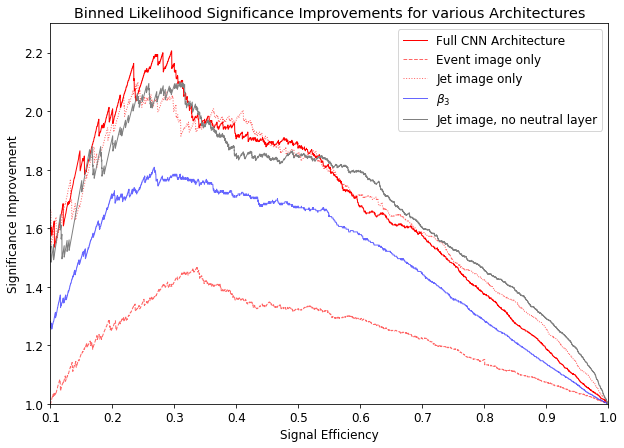

In [839]:
plt.figure(figsize=(10,7))
plt.title("Binned Likelihood Significance Improvements for various Architectures")
plt.plot(r_combine_x,r_combine_y,color="red",label="Full CNN Architecture",linewidth=1)
plt.plot(r_full_x,r_full_y,color="red",alpha=0.6,label="Event image only",linewidth=1,linestyle="dashed")
plt.plot(r_fine_x,r_fine_y,color="red",alpha=0.6,label="Jet image only",linewidth=1,linestyle="dotted")
plt.plot(beta_x,beta_y,color="blue",alpha=0.6,label=r"$\beta_3$",linewidth=1)#,linestyle="dashed")
#plt.plot(three_x,three_y,color="blue",alpha=0.6,label=r"$Rb_2$",linewidth=1,linestyle="dotted")
plt.plot(x_02,y_02,color="gray",label="Jet image, no neutral layer",linewidth=1)
#plt.plot(vars_y,vars_x,color="blue",label=r"$\beta_3 + Rb_2$",linewidth=1)
plt.xlim(0.1,1)
plt.ylim(1,2.3)
plt.legend()
plt.xlabel("Signal Efficiency")
plt.ylabel("Significance Improvement")
plt.savefig('all_SIC.eps')
plt.show()